# Satellite imagery access and analysis in Python & Jupyter notebooks


## Access, preprocess, analyse and visualize satellite images in Jupyter notebooks with Python.

### Accessing data
In this tutorial, we will use Sentinel 2 data. There are many options to access Sentinel 2 images and most of them will require you to access through website interaction whether directly via a downloading service utility or via the cloud. However, since we are using Jupyter notebook, we will access them right here using, sentinelsat a python library which makes searching, retrieving and downloading Sentinel satellite images easy. So let us start installing sentinelsat through pip.

In [1]:
%config IPCompleter.greedy=True
import folium
import os
import requests
from zipfile import ZipFile
import numpy as np
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt, make_path_filter
from six.moves.urllib.parse import urljoin
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona
import pyproj
import gdal
from datetime import datetime
import pygc
from io import StringIO
import shutil
import cv2
from sklearn import cluster
from osgeo import gdal, gdal_array
from sklearn.cluster import KMeans
from PIL import Image
import scipy.misc
import json
import logging


In [2]:
missing_values = [r"\N"]
df0 = pd.read_csv(r'airport-codes_csv.csv',na_values = missing_values)
list1,a,b = [],[],[]
for item in df0["iata_code"]:
    list1.append(item)
    
for items in df0['coordinates']:
    a.append(items.split(',')[0])
    b.append(items.split(',')[1])

______________

In [3]:
iatalist,iatabatch= [],[]
batch_ranges = []
batch_size = 1923
batch_number = 1
missing_values = [r"\N"]
df = pd.read_csv(r'airportDB.csv')
df_all = df
 
allNames = []
for items,names in zip(df_all['IATA'],df_all['Name']):
    iatabatch.append(items)
    allNames.append(names)
    
def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list 

iatabatch = Remove(iatabatch)
chunk_items = len(iatabatch) - 1

for i in range(chunk_items):
    batch_ranges.append(iatabatch[i*batch_size : (i+1)*batch_size])
    
batch_ranges

for i in range(batch_size):
    iatalist.append(batch_ranges[batch_number -1][i])
#print(iatalist)

        

iata,iatalat,iatalon,notthere = [],[],[],[]
for key in iatalist:
    try:
        iata.append(key)
        #have changed codes --> list1 & codes[key].lat/lon --> a/b[list1.index(key)]
        iatalon.append(a[list1.index(key)])
        iatalat.append(b[list1.index(key)])
    except:
        continue

airportName = iatalist.index('SIN') + 1

In [4]:
airportName

19

In [5]:
iatalist,iatabatch= [],[]
batch_ranges = []
batch_size = 1
batch_number = airportName
missing_values = [r"\N"]
df = pd.read_csv(r'airportDB.csv')
df_all = df
 
allNames = []
for items,names in zip(df_all['IATA'],df_all['Name']):
    iatabatch.append(items)
    allNames.append(names)
    
def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list 

iatabatch = Remove(iatabatch)
chunk_items = len(iatabatch) - 1

for i in range(chunk_items):
    batch_ranges.append(iatabatch[i*batch_size : (i+1)*batch_size])
    
batch_ranges

for i in range(batch_size):
    iatalist.append(batch_ranges[batch_number -1][i])
#print(iatalist)

        

iata,iatalat,iatalon,notthere = [],[],[],[]
for key in iatalist:
    iata.append(key)
    #have changed codes --> list1 & codes[key].lat/lon --> a/b[list1.index(key)]
    iatalon.append(a[list1.index(key)])
    iatalat.append(b[list1.index(key)])


#print(iata[0],iatalat[0],iatalon[0])
#printing the entries that we have in our excel but not in our database(significantly improved results over the .dat file previously supplied)
iatalist

['SIN']

In [6]:
def latLonBoxByWandH(lat,lon,ew_width,ns_height):
    lats, lons = [], []
    #distance in m, az (in deg), lat (in deg), long (in deg)

    res = pygc.great_circle(distance=ew_width/2, azimuth=90, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']

    res = pygc.great_circle(distance=ns_height/2, azimuth=180, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)

    res = pygc.great_circle(distance=ew_width, azimuth=270, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)

    res = pygc.great_circle(distance=ns_height, azimuth=0, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)

    res = pygc.great_circle(distance=ew_width, azimuth=90, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)
    
    return {'lats':lats,'lons':lons}


#test the function
#lengths in m
ew_width = 5000
ns_height = 5000
loc_lat,loc_lon = [], []

# iatalat = [1.419582]  
# iatalon = [103.796708]

for i in range(0,len(iata)):
    #print(iatalat[i],iatalon[i])
    loc_lat.append(iatalat[i])
    loc_lon.append(iatalon[i])


#loc_lon,loc_lat
loc_lat = np.asfarray(loc_lat,float)
loc_lon = np.asfarray(loc_lon,float)

#loc_lat = [39.509714]
#loc_lon = [116.410561]

#loc_lat = [13.052984]
#loc_lon = [80.282384]

loc_lat,loc_lon

(array([1.35019]), array([103.994003]))

In [7]:
polygons,footprint =[], []

for lat, lon in zip(loc_lat,loc_lon):

    box = latLonBoxByWandH(lat,lon,ew_width,ns_height)
    
    polygon_geom = Polygon(zip(box['lons'], box['lats']))
    footprint.append(polygon_geom)
    crs = {'init' : 'epsg:4326'}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
    #polygon.to_crs('WGS',4326)
    polygons.append(polygon)


pyproj.Proj("init =epsg:4326")
m = folium.Map([loc_lat[0],loc_lon[0]], zoom_start=12)
for polygon in polygons:
    folium.GeoJson(polygon).add_to(m)
m


C:\Anaconda3\envs\fastai_v1\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Anaconda3\envs\fastai_v1\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [8]:
user = 'demi12395' 
password = 'Sutd1234' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
# api.download()
start = '20200110'
end = '20210715'
cloudperc = 5
limit = 45

In [9]:
def apiQuery(iatalist,geometry,dateStart,dateEnd,cloud,lt):
    query = api.query(geometry,
                 date = (str(dateStart),str(dateEnd)),
                 platformname = 'Sentinel-2',
                 processinglevel = 'Level-2A',
                area_relation = ('Contains'),
                limit = lt,
                 cloudcoverpercentage = (0,cloud))
    return query

In [10]:
apiq = []
for ia,boundary in tqdm(zip(iatalist,footprint),total=len(iatalist)):
    queried = apiQuery(ia,boundary,start,end,cloudperc,limit)
    while len(queried) == 0:
        queried = apiQuery(ia,boundary,start,end,cloudperc+10,limit)
    apiq.append(queried)
    print(f"\n{ia},{len(queried)}")

100%|██████████| 1/1 [00:04<00:00,  4.82s/it]
SIN,4



In [11]:
products_list, products_list_sorted,images,titlelist,datestamp,cloudiness, datestampWithClouds =[],[], [], [], [] , [],[]
for products in apiq:
        products_list.append(api.to_geodataframe(products))
        
#Sorting the list of products within our array of locations for minimum cloudcover
for products in products_list:
    products_list_sorted.append(products.sort_values(['cloudcoverpercentage'],ascending = [True]))
    

# for i in range(0,len(products_list_sorted)):
#         images.append(products_list_sorted[i].head(1))

for i in range(0, len(products_list_sorted[0])):
        # print(products)
    titlelist.append(products_list_sorted[0].title[0])
    d = products_list_sorted[0].beginposition[0].date().strftime("%Y%m%d")
    c = products_list_sorted[0].cloudcoverpercentage
    datestamp.append(d)
    datestampWithClouds.append((d,c[1]))
    cloudiness.append(c)

In [12]:
bestlist = list(products_list_sorted[0]['uuid'])

In [13]:
datestampWithClouds

[('20210425', 13.136637),
 ('20210425', 13.136637),
 ('20210425', 13.136637),
 ('20210425', 13.136637)]

In [14]:
bestlist

['7c4fc429-92b4-42bd-963e-4eb6174c238d',
 '185e95e0-31b0-4958-851b-ee65fc59c86c',
 '163319ec-dbef-4351-88f3-3ae0c356ddb4',
 'd3662d18-d593-4e07-a9c9-10e36862f74c']

In [15]:
prodlist = bestlist


In [16]:
odata = api.get_product_odata(bestlist[2],full=True)
odata.keys()

dict_keys(['id', 'title', 'size', 'md5', 'date', 'footprint', 'url', 'Online', 'Creation Date', 'Ingestion Date', 'Aot retrieval accuracy', 'Cloud cover percentage', 'Cloud shadow percentage', 'Dark features percentage', 'Date', 'Degraded ancillary data percentage', 'Degraded MSI data percentage', 'Filename', 'Footprint', 'Format', 'Format correctness', 'General quality', 'Generation time', 'Geometric quality', 'High proba clouds percentage', 'Identifier', 'Instrument', 'Instrument abbreviation', 'Instrument name', 'JTS footprint', 'Medium proba clouds percentage', 'Mission datatake id', 'No data pixel percentage', 'Not vegetated percentage', 'NSSDC identifier', 'Orbit number (start)', 'Pass direction', 'Platform serial identifier', 'Processing baseline', 'Processing level', 'Product type', 'Radiometric quality', 'Relative orbit (start)', 'Satellite', 'Satellite name', 'Satellite number', 'Saturated defective pixel percentage', 'Sensing start', 'Sensing stop', 'Sensor quality', 'Size',

In [17]:
odata["Granule identifier"][25:40]

KeyError: 'Granule identifier'

In [ ]:
zipped = odata["title"] + ".zip" + "/"
folder = odata["title"] + ".SAFE" + "/"
granule = "GRANULE" + "/"
tile = "L2A_" + odata["Granule identifier"][49:55] + "_" + odata["Granule identifier"][41:48] + "_" + odata["Granule identifier"][25:40]  + "/"
folder2 = "IMG_DATA/R10m/"
filename = odata["Granule identifier"][49:55] + "_" + odata["Granule identifier"][25:40] + "_TCI_10m.jp2"

# fullpath = f"{zipped} + {folder} + {granule} + {tile}+ {folder2} + {filename}"
fullpath = f"{filename}"
fullpath

fullpathTest = "./" + zipped + folder + "manifest.safe"
fullpathTest


In [20]:
import logging
logging.basicConfig(level=logging.DEBUG)
# logging.basicConfig(level=logging.d)
nodefilter = make_path_filter("*S2A_MSIL2A_20210430T045651_N0300_R119_T44PMV_20210430T071033.zip/S2A_MSIL2A_20210430T045651_N0300_R119_T44PMV_20210430T071033.SAFE/AUX_DATA/*")
api.download(bestlist[2],"./Products/", nodefilter = nodefilter)


DEBUG:urllib3.connectionpool:https://scihub.copernicus.eu:443 "GET /dhus/odata/v1/Products('163319ec-dbef-4351-88f3-3ae0c356ddb4')?$format=json HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://scihub.copernicus.eu:443 "GET /dhus/odata/v1/Products('163319ec-dbef-4351-88f3-3ae0c356ddb4')/Attributes('Filename')/Value/$value HTTP/1.1" 200 65
INFO:sentinelsat.SentinelAPI:Downloading 163319ec-dbef-4351-88f3-3ae0c356ddb4 to Products\S2B_MSIL2A_20200420T031539_N0214_R118_T48NUG_20200420T072439.zip
DEBUG:urllib3.connectionpool:https://scihub.copernicus.eu:443 "GET /dhus/odata/v1/Products('163319ec-dbef-4351-88f3-3ae0c356ddb4')/$value HTTP/1.1" 500 0


ServerError: HTTP status 500 Internal Server Error: NullPointerException

In [21]:
prodlist

['7c4fc429-92b4-42bd-963e-4eb6174c238d',
 '185e95e0-31b0-4958-851b-ee65fc59c86c',
 '163319ec-dbef-4351-88f3-3ae0c356ddb4',
 'd3662d18-d593-4e07-a9c9-10e36862f74c']

In [22]:
len(iatalist)

1

In [23]:
### https://apihub.copernicus.eu/apihub/odata/v1/Products('6b70097e-0b03-4d15-b0ba-780423103205')/Nodes('S2A_MSIL2A_20201104T183541_N0214_R027_T11SLT_20201104T210809.SAFE')/Nodes('GRANULE')/Nodes('L2A_T11SLT_A028052_20201104T183645')/Nodes('IMG_DATA')/Nodes('R10m')/Nodes('T11SLT_20201104T183541_TCI_10m.jp2')/$value

In [24]:
def getImageURLs(prod_id):
    urls,fNames = [],[]


    # connect to the api
    api_session = requests.Session()
    api_session.auth = ("demi12395", "Sutd1234")
    api_url = "https://apihub.copernicus.eu/apihub/odata/v1/"
    formatting = "?$format=json"

    # product UUID you want to download a single band for
    for ids in tqdm(prod_id,total=len(prodlist)):
        #print(ia)
        # parse the product name
        node_url = f"Products('{ids}'){formatting}"
        nodes = api_session.get(urljoin(api_url, node_url)).json()
        # nodes = api_session.get(urljoin(api_url, "Products('%s')/Nodes?$format=json" % ids)).json()
        # test_url = "https://apihub.copernicus.eu/apihub/odata/v1/Products('d9ade782-f4cf-40d7-a7e4-05b9242f9de3')/Nodes?$format=json"
        # print(nodes["d"]["Name"])
        # prod_name = nodes["d"]["results"][0]["id"]
        prod_name = f"{nodes['d']['Name']}.SAFE"
    #     print('prod_name {}'.format(prod_name))

        # parse the granule id
        gran_url = f"Products('{ids}')/Nodes('{prod_name}')/Nodes('GRANULE')/Nodes?$format=json"
        granules = api_session.get(urljoin(api_url, gran_url )).json()
        granules["d"]["results"][0].keys()
        gran_id = granules["d"]["results"][0]["Id"]
    #     print('granule {}'.format(gran_id))



        # parse the band names
        bands_url = f"Products('{ids}')/Nodes('{prod_name}')/Nodes('GRANULE')/Nodes('{gran_id}')/Nodes('IMG_DATA')/Nodes?$format=json"
        bands = api_session.get(urljoin(api_url, bands_url )).json()
        band_id = bands["d"]["results"][0]["Id"]  # element 3 is band 4, element 0 band 1
    #     print('band {}'.format(band_id))


        # construct the final image url
        tci = f"Products('{ids}')/Nodes('{prod_name}')/Nodes('GRANULE')/Nodes('{gran_id}')/Nodes('IMG_DATA')/Nodes('{band_id}')/Nodes?$format=json"
        TCI_url = api_session.get(urljoin(api_url, tci)).json()
        TCI_id = TCI_url["d"]["results"][5]["Id"]
    #     print('TCI_ID {}'.format(TCI_id))

        img = f"Products('{ids}')/Nodes('{prod_name}')/Nodes('GRANULE')/Nodes('{gran_id}')/Nodes('IMG_DATA')/Nodes('{band_id}')/Nodes('{TCI_id}')/$value"
        img_url = urljoin(api_url, img)
        urls.append(img_url)
        fNames.append(TCI_id)
    return urls,fNames

In [25]:
def getImages(fNames,urls):
    for names,urls in tqdm(fNames,urls,total=len(prodlist)):

        r = requests.get(urls,auth = (user,password))
        with open("Products_R/" + str(ia) + "_" + str(names),'wb') as f: 
            f.write(r.content) 
        f.close()

In [26]:
urlLinks,tileNames = getImageURLs(prodlist)

  0%|          | 0/4 [00:00<?, ?it/s]DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): apihub.copernicus.eu:443
DEBUG:urllib3.connectionpool:https://apihub.copernicus.eu:443 "GET /apihub/odata/v1/Products('7c4fc429-92b4-42bd-963e-4eb6174c238d')?$format=json HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://apihub.copernicus.eu:443 "GET /apihub/odata/v1/Products('7c4fc429-92b4-42bd-963e-4eb6174c238d')/Nodes('S2B_MSIL2A_20210425T031539_N0300_R118_T48NUG_20210425T064056.SAFE')/Nodes('GRANULE')/Nodes?$format=json HTTP/1.1" 500 416
  0%|          | 0/4 [00:01<?, ?it/s]


KeyError: 'd'

In [81]:
#kth best image available
urlLinks[1]

In [82]:
getImages(tileNames,urlLinks,iatalist)

[['163319ec-dbef-4351-88f3-3ae0c356ddb4',
  'c4e9f7b2-459c-4cdc-a0f9-bb43bb56d32a',
  '84b0da69-4a1c-4128-a34d-5b10d2891419',
  'a57feb54-edf5-401d-834d-15d1fd63c720',
  '6ba43896-ae4e-4a93-bbf3-c1f2e971a31a',
  'b31c3d8b-b0b9-402a-966d-08f9acae22a9',
  'fa1fa299-d574-4304-8ae8-7fb9d2728ffd',
  'ce60cba7-43c2-46ab-83fa-c2f64f273426',
  'f5f3eb1b-41d6-4a08-97f9-c41514512951',
  'a897278d-2337-4359-9036-dc4125375bc5',
  'eec33f73-70d6-47fa-9324-436abc1839a3',
  'beb65a67-2b72-4367-9386-a226bcc5751b',
  '6f5b7b30-22d3-46f7-9973-3572c6bfa82f',
  '8d560699-43be-4ebe-a6ad-b47edb1e7a3d']]

In [83]:
path = "Products_R/"
sortedFileList = []
for ia in iatalist:
    for files in os.listdir(path):
        if files.endswith(".jp2") and files[:3] == ia:
            sortedFileList.append(files)
#sortedFileList

[['S2B_MSIL2A_20200420T031539_N0214_R118_T48NUG_20200420T072439',
  'S2A_MSIL2A_20200225T031711_N0214_R118_T48NUG_20200225T072321',
  'S2A_MSIL2A_20200205T031921_N0214_R118_T48NUG_20200205T071906',
  'S2A_MSIL2A_20200106T032121_N0213_R118_T48NUG_20200106T070716',
  'S2A_MSIL2A_20191227T032131_N0213_R118_T48NUG_20191227T065256',
  'S2A_MSIL2A_20191117T032021_N0213_R118_T48NUG_20191117T072120',
  'S2A_MSIL2A_20190819T031541_N0213_R118_T48NUG_20190819T091330',
  'S2B_MSIL2A_20190526T031549_N0212_R118_T48NUG_20190526T082540',
  'S2B_MSIL2A_20190506T031549_N0212_R118_T48NUG_20190521T170459',
  'S2B_MSIL2A_20190406T031549_N0211_R118_T48NUG_20190406T081857',
  'S2B_MSIL2A_20190327T031729_N0211_R118_T48NUG_20190327T091421',
  'S2B_MSIL2A_20190225T031719_N0211_R118_T48NUG_20190225T081710',
  'S2B_MSIL2A_20190106T032129_N0211_R118_T48NUG_20190106T090342',
  'S2A_MSIL2A_20190101T032131_N0211_R118_T48NUG_20190101T072239']]

In [85]:
rankList = list(dataRanks.keys())

Downloading: 100%|████████████████████████████████████████████████████████████████| 1.10G/1.10G [03:12<00:00, 5.72MB/s]
MD5 checksumming: 100%|████████████████████████████████████████████████████████████| 1.10G/1.10G [00:06<00:00, 173MB/s]


extracting  S2B_MSIL2A_20200420T031539_N0214_R118_T48NUG_20200420T072439
Unzipping complete.. Now removing the file..


Downloading: 100%|████████████████████████████████████████████████████████████████| 1.10G/1.10G [03:19<00:00, 5.49MB/s]
MD5 checksumming: 100%|████████████████████████████████████████████████████████████| 1.10G/1.10G [00:05<00:00, 211MB/s]


extracting  S2A_MSIL2A_20200225T031711_N0214_R118_T48NUG_20200225T072321
Unzipping complete.. Now removing the file..


Downloading: 100%|████████████████████████████████████████████████████████████████| 1.07G/1.07G [03:16<00:00, 5.43MB/s]
MD5 checksumming: 100%|████████████████████████████████████████████████████████████| 1.07G/1.07G [00:05<00:00, 188MB/s]


extracting  S2A_MSIL2A_20200205T031921_N0214_R118_T48NUG_20200205T071906
Unzipping complete.. Now removing the file..


Downloading: 100%|████████████████████████████████████████████████████████████████| 1.08G/1.08G [03:21<00:00, 5.37MB/s]
MD5 checksumming: 100%|████████████████████████████████████████████████████████████| 1.08G/1.08G [00:05<00:00, 185MB/s]


extracting  S2A_MSIL2A_20200106T032121_N0213_R118_T48NUG_20200106T070716
Unzipping complete.. Now removing the file..


Downloading: 100%|████████████████████████████████████████████████████████████████| 1.07G/1.07G [03:27<00:00, 5.17MB/s]
MD5 checksumming: 100%|████████████████████████████████████████████████████████████| 1.07G/1.07G [00:02<00:00, 376MB/s]


extracting  S2A_MSIL2A_20191227T032131_N0213_R118_T48NUG_20191227T065256
Unzipping complete.. Now removing the file..


Downloading: 100%|████████████████████████████████████████████████████████████████| 1.06G/1.06G [02:27<00:00, 7.20MB/s]
MD5 checksumming: 100%|████████████████████████████████████████████████████████████| 1.06G/1.06G [00:02<00:00, 376MB/s]


extracting  S2A_MSIL2A_20191117T032021_N0213_R118_T48NUG_20191117T072120
Unzipping complete.. Now removing the file..


Downloading: 100%|████████████████████████████████████████████████████████████████| 1.08G/1.08G [03:08<00:00, 5.74MB/s]
MD5 checksumming: 100%|████████████████████████████████████████████████████████████| 1.08G/1.08G [00:03<00:00, 343MB/s]


extracting  S2A_MSIL2A_20190819T031541_N0213_R118_T48NUG_20190819T091330
Unzipping complete.. Now removing the file..


Downloading: 100%|████████████████████████████████████████████████████████████████| 1.09G/1.09G [02:46<00:00, 6.57MB/s]
MD5 checksumming: 100%|████████████████████████████████████████████████████████████| 1.09G/1.09G [00:02<00:00, 379MB/s]


extracting  S2B_MSIL2A_20190526T031549_N0212_R118_T48NUG_20190526T082540
Unzipping complete.. Now removing the file..


Product f5f3eb1b-41d6-4a08-97f9-c41514512951 is not online. Triggering retrieval from long term archive.


Error! Skipping...


Downloading: 100%|████████████████████████████████████████████████████████████████| 1.09G/1.09G [05:04<00:00, 3.57MB/s]
MD5 checksumming: 100%|████████████████████████████████████████████████████████████| 1.09G/1.09G [00:03<00:00, 355MB/s]


extracting  S2B_MSIL2A_20190406T031549_N0211_R118_T48NUG_20190406T081857
Unzipping complete.. Now removing the file..


Product eec33f73-70d6-47fa-9324-436abc1839a3 is not online. Triggering retrieval from long term archive.


Error! Skipping...


Downloading: 100%|████████████████████████████████████████████████████████████████| 1.07G/1.07G [04:33<00:00, 3.92MB/s]
MD5 checksumming: 100%|████████████████████████████████████████████████████████████| 1.07G/1.07G [00:03<00:00, 348MB/s]


extracting  S2B_MSIL2A_20190225T031719_N0211_R118_T48NUG_20190225T081710
Unzipping complete.. Now removing the file..


Product 6f5b7b30-22d3-46f7-9973-3572c6bfa82f is not online. Triggering retrieval from long term archive.


Error! Skipping...


Downloading: 100%|████████████████████████████████████████████████████████████████| 1.07G/1.07G [03:19<00:00, 5.38MB/s]
MD5 checksumming: 100%|████████████████████████████████████████████████████████████| 1.07G/1.07G [00:02<00:00, 375MB/s]


extracting  S2A_MSIL2A_20190101T032131_N0211_R118_T48NUG_20190101T072239
Unzipping complete.. Now removing the file..


In [ ]:
fileNames,file = [],[]
targetPath = "Products/"
for items,meta,ia in tqdm(zip(sortedFileList,dataArr,iatalist),total = len(iatalist)):
    openFile = path + str(items)
    saveFile = targetPath + str(rankList.index(str(ia)) + 2) + "_"  + str(items)[:-4] + ".tiff"
    #print(openFile)
    input_raster = gdal.Open(openFile)
    #print(saveFile)
    fileNames.append(saveFile)
    gdal.Warp(saveFile,openFile,srcSRS = str(meta.meta['crs']),dstSRS = 'epsg:4326',width = str(meta.meta['width']),height = str(meta.meta['height']))


In [86]:
rankList.index('TMP')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'S2B_MSIL2A_20190506T031549_N0212_R118_T48NUG_20190521T170459.SAFE/GRANULE'

In [28]:
foldername

[['L2A_T18TWL_A016053_20200402T154806',
  'L2A_T18TWL_A024747_20200318T154349',
  'L2A_T18TWL_A024318_20200217T154553',
  'L2A_T18TWL_A014623_20191224T154843',
  'L2A_T18TWL_A023460_20191219T155110',
  'L2A_T18TWL_A013908_20191104T154510',
  'L2A_T18TWL_A013622_20191015T154912',
  'L2A_T18TWL_A013479_20191005T154756',
  'L2A_T18TWL_A013336_20190925T155023']]

In [29]:
dire[0]

[['T18TWL_20200402T153809_AOT_10m.jp2',
  'T18TWL_20200402T153809_B02_10m.jp2',
  'T18TWL_20200402T153809_B03_10m.jp2',
  'T18TWL_20200402T153809_B04_10m.jp2',
  'T18TWL_20200402T153809_B08_10m.jp2',
  'T18TWL_20200402T153809_TCI_10m.jp2',
  'T18TWL_20200402T153809_WVP_10m.jp2'],
 ['T18TWL_20200318T153941_AOT_10m.jp2',
  'T18TWL_20200318T153941_B02_10m.jp2',
  'T18TWL_20200318T153941_B03_10m.jp2',
  'T18TWL_20200318T153941_B04_10m.jp2',
  'T18TWL_20200318T153941_B08_10m.jp2',
  'T18TWL_20200318T153941_TCI_10m.jp2',
  'T18TWL_20200318T153941_WVP_10m.jp2'],
 ['T18TWL_20200217T154311_AOT_10m.jp2',
  'T18TWL_20200217T154311_B02_10m.jp2',
  'T18TWL_20200217T154311_B03_10m.jp2',
  'T18TWL_20200217T154311_B04_10m.jp2',
  'T18TWL_20200217T154311_B08_10m.jp2',
  'T18TWL_20200217T154311_TCI_10m.jp2',
  'T18TWL_20200217T154311_WVP_10m.jp2'],
 ['T18TWL_20191224T154649_AOT_10m.jp2',
  'T18TWL_20191224T154649_B02_10m.jp2',
  'T18TWL_20191224T154649_B03_10m.jp2',
  'T18TWL_20191224T154649_B04_10m.jp2

In [30]:
templatemp,template = [],[]
for k in range(0,len(dire)):
    for i in range(0,len(dire[0])):
        templatemp.append(dire[k][i][-2][0:][:-4])
    template.append(templatemp)
    templatemp = []
template

[['T18TWL_20200402T153809_TCI_10m',
  'T18TWL_20200318T153941_TCI_10m',
  'T18TWL_20200217T154311_TCI_10m',
  'T18TWL_20191224T154649_TCI_10m',
  'T18TWL_20191219T154641_TCI_10m',
  'T18TWL_20191104T154329_TCI_10m',
  'T18TWL_20191015T154219_TCI_10m',
  'T18TWL_20191005T154109_TCI_10m',
  'T18TWL_20190925T153959_TCI_10m']]

In [31]:
allmapscompleteinc,allmapscomplete = [],[]
for k in range(0,len(prodlist)):
    for i in range(0,len(prodlist[0])):
        allmapscompleteinc.append(allmaps[k][i] + "/" + template[k][i] + ".jp2")
    allmapscomplete.append(allmapscompleteinc)
    allmapscompleteinc = []
allmapscomplete[0]


['S2B_MSIL2A_20200402T153809_N0214_R011_T18TWL_20200402T195845.SAFE/GRANULE/L2A_T18TWL_A016053_20200402T154806/IMG_DATA/R10m/T18TWL_20200402T153809_TCI_10m.jp2',
 'S2A_MSIL2A_20200318T153941_N0214_R011_T18TWL_20200318T200228.SAFE/GRANULE/L2A_T18TWL_A024747_20200318T154349/IMG_DATA/R10m/T18TWL_20200318T153941_TCI_10m.jp2',
 'S2A_MSIL2A_20200217T154311_N0214_R011_T18TWL_20200217T195800.SAFE/GRANULE/L2A_T18TWL_A024318_20200217T154553/IMG_DATA/R10m/T18TWL_20200217T154311_TCI_10m.jp2',
 'S2B_MSIL2A_20191224T154649_N0213_R011_T18TWL_20191224T194612.SAFE/GRANULE/L2A_T18TWL_A014623_20191224T154843/IMG_DATA/R10m/T18TWL_20191224T154649_TCI_10m.jp2',
 'S2A_MSIL2A_20191219T154641_N0213_R011_T18TWL_20191219T194623.SAFE/GRANULE/L2A_T18TWL_A023460_20191219T155110/IMG_DATA/R10m/T18TWL_20191219T154641_TCI_10m.jp2',
 'S2B_MSIL2A_20191104T154329_N0213_R011_T18TWL_20191104T194538.SAFE/GRANULE/L2A_T18TWL_A013908_20191104T154510/IMG_DATA/R10m/T18TWL_20191104T154329_TCI_10m.jp2',
 'S2B_MSIL2A_20191015T154219

In [32]:
data = rio.open(allmapscomplete[0][2])
print(data.meta['crs'])

EPSG:32618


In [33]:
data.count, data.width, data.height

(3, 10980, 10980)

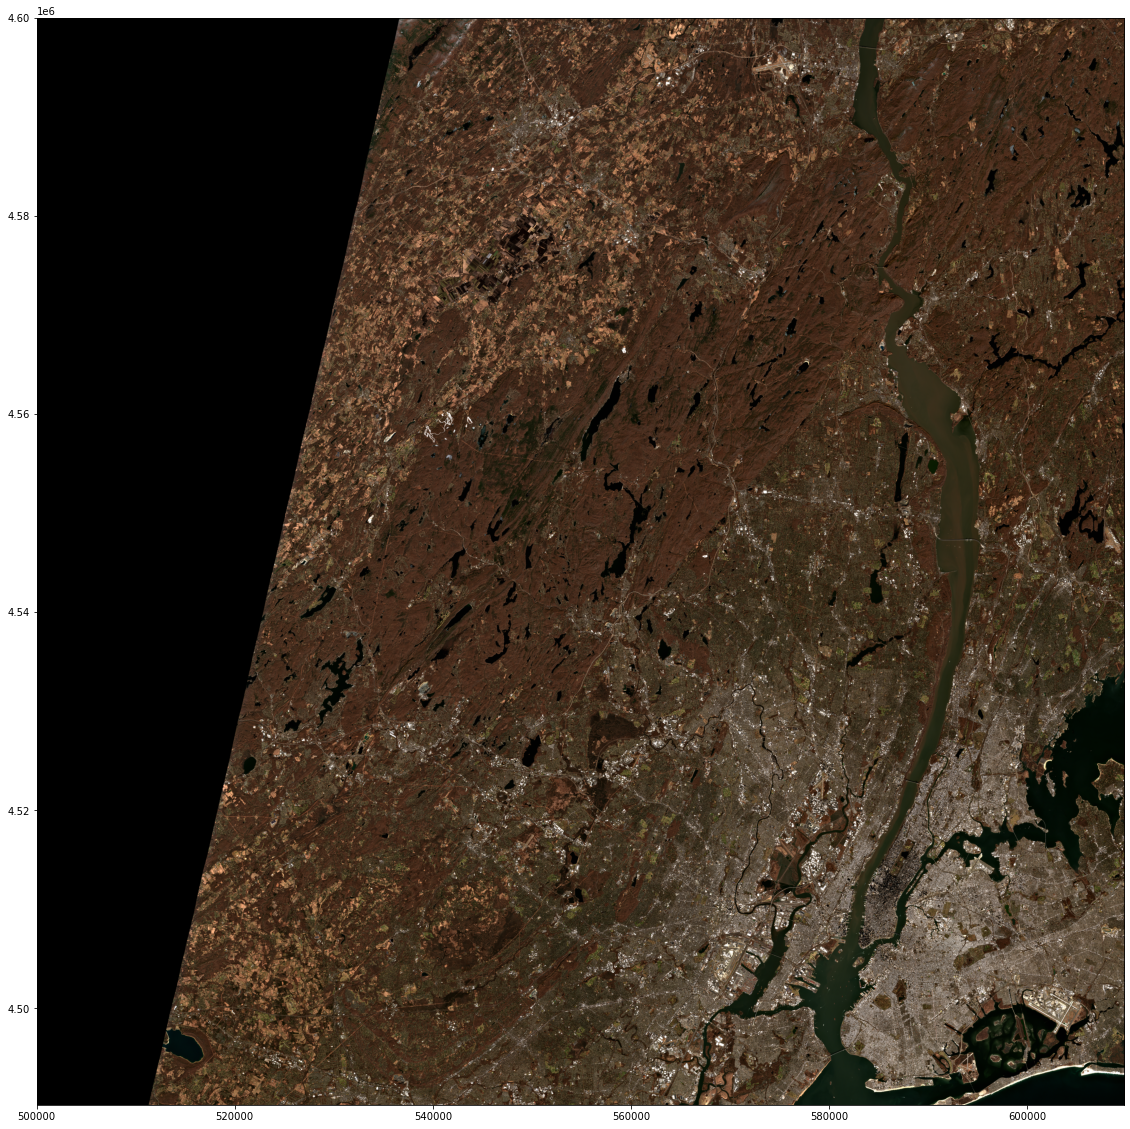

In [34]:
fig, ax = plt.subplots(1, figsize=(20, 20))
show(data, ax=ax)
plt.show()

### Mask Satellite images

In [35]:
filename,file = [],[]
gdoptions = gdal.WarpOptions(options = ['EPSG:4326','width=10980', "height=10980"])
#gdoptions = gdal.WarpOptions('dstSRS = WGS84','width = 10980','height = 10980')
for k in range(0,len(allmaps)):
    for i in range(0,len(allmaps[0])):
        input_raster = gdal.Open(allmapscomplete[k][i])
        output_raster = allmaps[k][i] + '/' + template[k][i] +".tiff"
        file.append(output_raster)
        options=['dstSRS = EPSG:4326','width = 10980', 'height = 10980']
        gdal.Warp(output_raster,input_raster,srcSRS = str(data.meta['crs']),dstSRS = 'epsg:4326',width = str(data.width),height = str(data.height))
        print("{} Finished Warping for {}_{}".format(i+1,str(k),iatalist[k]))
    filename.append(file)
    file = []
    #break


1 Finished Warping for 0_JFK
2 Finished Warping for 0_JFK
3 Finished Warping for 0_JFK
4 Finished Warping for 0_JFK
5 Finished Warping for 0_JFK
6 Finished Warping for 0_JFK
7 Finished Warping for 0_JFK
8 Finished Warping for 0_JFK
9 Finished Warping for 0_JFK


In [26]:
for items in filename[0]:
    data = rio.open(items)
print(data.meta['crs'])

EPSG:4326


In [27]:
polygons[0].crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
key = 'TP_HEL_'

In [29]:
from rasterio.mask import mask

geoms,namesofFiles = [],[]
for i in range(0,len(datestamp)):
    geoms.append(polygons[i]['geometry'])

for k in range(0,len(prodlist)):
    for i in range(0,len(prodlist[0])):
        with rasterio.open(filename[k][i]) as src:
            out_image, out_transform = mask(src, geoms[0], crop=True)
            out_meta = src.meta.copy()

        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform
                        })
        files = 'Source/S1_' + key + datestamp[k][i] + '.tiff'
        namesofFiles.append(files)
        with rasterio.open(files, "w", **out_meta) as dest:
            dest.write(out_image)
        #os.remove(titlelist[k][i])

In [30]:
namesofFiles

['Source/S1_TP_HEL_20200404.tiff',
 'Source/S1_TP_HEL_20200328.tiff',
 'Source/S1_TP_HEL_20200320.tiff',
 'Source/S1_TP_HEL_20200315.tiff',
 'Source/S1_TP_HEL_20200125.tiff',
 'Source/S1_TP_HEL_20191030.tiff',
 'Source/S1_TP_HEL_20190927.tiff',
 'Source/S1_TP_HEL_20190902.tiff',
 'Source/S1_TP_HEL_20190828.tiff',
 'Source/S1_TP_HEL_20190801.tiff']

### Save as GIF

In [31]:
from PIL import Image, ImageDraw,ImageFont
images = []

for things,i in zip(reversed(namesofFiles),reversed(datestamp[0])):
    img = Image.open(things)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", 18)
    draw.text((50, 50),str(i),(255,255,255),font=font)
    images.append(img)
images[0].save(key + iatalist[0] + '.gif',
              save_all=True, append_images=images[1:], optimize=True, duration=800, loop=0)   

### Save as Video

In [257]:
import cv2
import os

video_name = key + iatalist[0] + '.avi'

frame = cv2.imread(namesofFiles[0])
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in reversed(namesofFiles):
    video.write(cv2.imread(image))

cv2.destroyAllWindows()
video.release()